# Fit an orbit

This title is something of a bait-and-switch, since `jorbit` does not contain any self-contained code to "fit" an orbit in a Bayesian sense. It does, however, have the ability to easily evaluate the *likelihood* of a given state vector compared to a set of observations, the *derivative* of that likelihood with respect to each componet of that state vector, and a wrapper for finding the maximum likelihood state vector using the L-BFGS-B algorithm. Actually computing the posterior distribution of each orbital element is on you: feel free to use your favorite MCMC or nested sampling package!

Below demonstrates some of the functions that might be useful in that process.

In [54]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroquery.jplhorizons import Horizons

from jorbit import Particle, Observations
from jorbit.utils.states import KeplerianState, CartesianState

First, let's use Horizons to generate some fake obersvations of an asteroid:

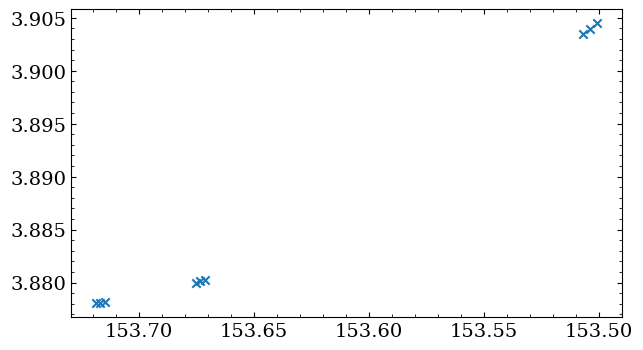

In [9]:
nights = [Time("2025-01-01 07:00"), Time("2025-01-02 07:00"), Time("2025-01-05 07:00")]

times = []
for n in nights:
    times.extend([n + i * 1 * u.hour for i in range(3)])
times = Time(times)

obj = Horizons(id="274301", location="695@399", epochs=times.utc.jd)
pts = obj.ephemerides(extra_precision=True, quantities="1")

coords = SkyCoord(pts["RA"], pts["DEC"], unit=(u.deg, u.deg))
times = Time(pts["datetime_jd"], format="jd", scale="utc")

fig, ax = plt.subplots()
ax.scatter(coords.ra.deg, coords.dec.deg, marker="x")
ax.invert_xaxis()

Now we can use those to create an `Observations` object:

In [12]:
obs = Observations(
    observed_coordinates=coords,
    times=times,
    observatories="kitt peak",
    astrometric_uncertainties=1 * u.arcsec,
)

This pre-computes the appropriate covariance matrices of the observations and caches the barycentric positions of the observer according to Horizons. Note that all of the likelihood calculations within `Particle` are built on the assumption that the observer's position is known exactly, and that the planets/major asteroids are exactly where Horizons says they are.


Let's now create two `Particle` objects, one with the "correct" underlying state accoridng to Horizons and one that's slightly perturbed:

In [25]:
obj = Horizons(id="274301", location="500@0", epochs=times.tdb.jd[0])
vecs = obj.vectors(refplane="earth")
true_x0 = jnp.array([vecs["x"], vecs["y"], vecs["z"]]).T[0]
true_v0 = jnp.array([vecs["vx"], vecs["vy"], vecs["vz"]]).T[0]


p_true = Particle(
    x=true_x0, v=true_v0, time=times[0], name="274301 Wikipedia", observations=obs
)

p_perturbed = Particle(
    x=true_x0 + jnp.ones(3) * 1e-1,
    v=true_v0 - jnp.ones(3) * 1e-3,
    time=times[0],
    name="274301 Perturbed",
    observations=obs,
)

We can take a look at the differences between these particles by examining their orbital elements:

In [26]:
print(p_true._keplerian_state)
print(p_perturbed._keplerian_state)

KeplerianState(semi=Array([2.37859645], dtype=float64), ecc=Array([0.14924503], dtype=float64), inc=Array([6.733637], dtype=float64), Omega=Array([183.37294715], dtype=float64), omega=Array([140.26386151], dtype=float64), nu=Array([173.65462561], dtype=float64), time=np.float64(2460676.792467407))
KeplerianState(semi=Array([3.3054992], dtype=float64), ecc=Array([0.17673654], dtype=float64), inc=Array([3.87846674], dtype=float64), Omega=Array([208.08713623], dtype=float64), omega=Array([306.18498785], dtype=float64), nu=Array([339.74156969], dtype=float64), time=np.float64(2460676.792467407))


The highest-level built in function that's relevant here is `max_likelihood`, which will create a new `Particle` object that's represents maximum likelihood of the observations:

In [27]:
p_best_fit = p_perturbed.max_likelihood(verbose=True)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =          100

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07889D+02    |proj g|=  5.53857D+06


 This problem is unconstrained.



At iterate    1    f=  2.31464D+02    |proj g|=  3.66558D+06

At iterate    2    f=  1.87597D+02    |proj g|=  3.28397D+06

At iterate    3    f=  1.65411D+01    |proj g|=  6.60343D+03

At iterate    4    f=  1.65411D+01    |proj g|=  1.09481D+01

At iterate    5    f=  1.65411D+01    |proj g|=  6.97991D+00

At iterate    6    f=  1.65411D+01    |proj g|=  7.84959D+00

At iterate    7    f=  1.65411D+01    |proj g|=  2.19358D+01

At iterate    8    f=  1.65411D+01    |proj g|=  3.70241D+01

At iterate    9    f=  1.65411D+01    |proj g|=  5.39193D+01

At iterate   10    f=  1.65411D+01    |proj g|=  6.52466D+01

At iterate   11    f=  1.65411D+01    |proj g|=  8.35037D+01

At iterate   12    f=  1.65411D+01    |proj g|=  1.18283D+02

At iterate   13    f=  1.65411D+01    |proj g|=  1.70961D+02

At iterate   14    f=  1.65411D+01    |proj g|=  2.58135D+02

At iterate   15    f=  1.65411D+01    |proj g|=  3.97437D+02

At iterate   16    f=  1.65411D+01    |proj g|=  6.16287D+02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Qualitatively, we can see how well this worked by again examining the orbital elements:

In [29]:
print(p_true._keplerian_state)
print(p_best_fit._keplerian_state)

KeplerianState(semi=Array([2.37859645], dtype=float64), ecc=Array([0.14924503], dtype=float64), inc=Array([6.733637], dtype=float64), Omega=Array([183.37294715], dtype=float64), omega=Array([140.26386151], dtype=float64), nu=Array([173.65462561], dtype=float64), time=np.float64(2460676.792467407))
KeplerianState(semi=Array([2.37724556], dtype=float64), ecc=Array([0.14982437], dtype=float64), inc=Array([6.73733133], dtype=float64), Omega=Array([183.34436248], dtype=float64), omega=Array([139.77665977], dtype=float64), nu=Array([174.17189529], dtype=float64), time=np.float64(2460676.792467407))


Quantitatively, we can see how well this worked by examining the residuals and likelihoods:

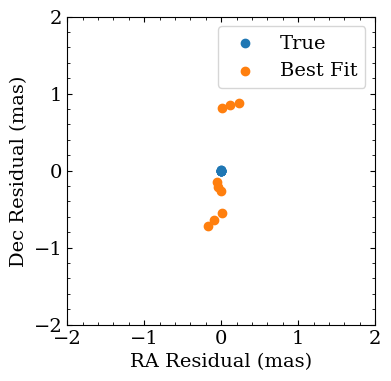

In [49]:
res_true = p_true.residuals(p_true._keplerian_state)
res_perturbed = p_perturbed.residuals(p_perturbed._keplerian_state)
res_best_fit = p_best_fit.residuals(p_best_fit._keplerian_state)

fig, ax = plt.subplots()
ax.scatter(res_true[:, 0] * 1e3, res_true[:, 1] * 1e3, label="True")
ax.scatter(res_best_fit[:, 0] * 1e3, res_best_fit[:, 1] * 1e3, label="Best Fit")
w = 2
ax.set(
    xlim=(-w, w),
    ylim=(-w, w),
    aspect="equal",
    xlabel="RA Residual (mas)",
    ylabel="Dec Residual (mas)",
)
ax.legend()

Naturally if we had added noise to the observations the residuals wouldn't be this small, but it's reassuring that we can go from $>$ degree errors to sub-arcsecond residuals without too much trouble.

Next let's take a look at the likelihoods:

In [52]:
print(f"p_true: {p_true.loglike(p_true._keplerian_state)}")
print(f"p_perturbed: {p_perturbed.loglike(p_perturbed._keplerian_state)}")
print(f"p_best_fit: {p_best_fit.loglike(p_best_fit._keplerian_state)}")

p_true: -16.540893597693742
p_perturbed: -1354314070.3882532
p_best_fit: -16.540895416745737


This confirms that our `max_likelihood` function is doing what we expect: increasing the loglikelihood to about as high as it can go.

This gives us an excuse to consider the loglike function some more. It will compute the log likelihood of either a given KeplerianState or CartesianState without modifying the actual particle's state:

In [69]:
test_kep_state = KeplerianState(
    semi=jnp.array([2.37859645]),
    ecc=jnp.array([0.14924503]),
    inc=jnp.array([6.733637]),
    Omega=jnp.array([183.37294715]),
    omega=jnp.array([140.26386151]),
    nu=jnp.array([173.65462561]),
    time=2460676.792467407,
)

p_true.loglike(test_kep_state)

Array(-16.54089393, dtype=float64)

In [70]:
test_cart_state = test_kep_state.to_cartesian()
test_cart_state

CartesianState(x=Array([[-2.00572342,  1.77860129,  0.51974071]], dtype=float64), v=Array([[-0.00665991, -0.00662871, -0.00203885]], dtype=float64), time=2460676.792467407)

In [71]:
p_true.loglike(test_cart_state)

Array(-16.54089393, dtype=float64)

The neat thing is, since all of this is in JAX, we can compute the derivative of the likelihood with respect to each of the components of these states through the magic of automatic differentiation:

In [75]:
print(jax.grad(p_true.loglike)(test_kep_state))
print(jax.grad(p_true.loglike)(test_cart_state))

KeplerianState(semi=Array([-83.71298239], dtype=float64), ecc=Array([-174.08168795], dtype=float64), inc=Array([1.7646241], dtype=float64), Omega=Array([11.39086544], dtype=float64), omega=Array([11.26690248], dtype=float64), nu=Array([11.20261001], dtype=float64), time=Array(-2.01811611, dtype=float64))
CartesianState(x=Array([[-106.70949674, -197.81151021, -114.16105072]], dtype=float64), v=Array([[-188.69274729, -348.66031843, -199.38980932]], dtype=float64), time=Array(-2.01811611, dtype=float64))


This is pretty cool! This is the true gradient propagated all the way through all of the predictor-corrector iterations of IAS15 and all of the convergent iterations of the PPN-gravity function. Note that since we use jax.while loops in parts of the model, we can't use reverse-mode autodiff: even when you call jax.grad, it's really doing forward-mode autodiff via a custom_vjp.

Finally, for convenience, we also include a function that takes simple 1D arrays as inputs, which might be easier if using fitters like [emcee](https://emcee.readthedocs.io/en/stable/) or [dynesty](https://dynesty.readthedocs.io/en/stable/). These 1D arrays assume the first 3 elements are the barycentric ICRS x, y, and z positions in AU, and the next 3 are the barycentric ICRS x, y, and z velocities in AU/day. Note that the signs here are flipped: we assume that they're "objective" functions to be minimized rather than "log likelihoods" to be maximized.

In [73]:
one_d = jnp.concatenate([test_cart_state.x.flatten(), test_cart_state.v.flatten()])
one_d

Array([-2.00572342,  1.77860129,  0.51974071, -0.00665991, -0.00662871,
       -0.00203885], dtype=float64)

In [74]:
print(p_true.scipy_objective(one_d))
print(p_true.scipy_objective_grad(one_d))

16.540893933609993
[106.70949674 197.81151021 114.16105072 188.69274729 348.66031843
 199.38980932]
